In [1]:
!pip -q install scipy
!pip -q install numpy
!pip -q install tqdm
!pip -q install matplotlib
!pip -q install pandas

In [1]:
import sys
import numpy as np
import functools 
import pandas as pd
from scipy.stats import kendalltau
from collections import defaultdict
from utils import *
from numpy.random import choice
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scipy.stats

np.set_printoptions(precision=3)

In [2]:
path_log = './data/log.2.tsv'
path_topic = './data/topic.tsv'
path_sub_topic = './data/sub_topic.tsv'
path_retrievable_paragraph = './data/retrievable_paragraph.tsv'

In [3]:
topics = get_topics(path_topic)

topics

{1: 'harvard university',
 2: 'black death',
 3: 'intergovernmental panel on climate change',
 4: 'private schools',
 5: 'geology',
 6: 'economic inequality',
 7: 'immune system',
 8: 'oxygen',
 9: 'normans',
 10: 'amazon rainforest',
 11: 'european union law'}

In [4]:
sub_topics = get_sub_topics(path_sub_topic)

sub_topics

defaultdict(list,
            {10: [1, 2, 3, 4, 5],
             5: [6, 7, 8, 9, 10, 11],
             6: [12, 13, 14, 15, 16, 17],
             4: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
             2: [28, 29, 30, 31, 32],
             9: [33, 34, 35, 36],
             1: [37, 38, 39, 40, 41],
             8: [42, 43, 44, 45, 46, 47, 48, 49, 50],
             11: [51, 52, 53, 54, 55, 56, 57, 58, 59, 60],
             7: [61, 62, 63, 64, 65, 66],
             3: [67, 68, 69, 70, 71, 72]})

In [5]:
session_ids = get_session_ids(path_log)

session_ids

[('A1WH32GYQOHIRQ', 10),
 ('A12J4IRF5Z06BT', 7),
 ('A1PTH9KTRO06EG', 7),
 ('A23TGEQ4CG90PA', 1),
 ('A3C2X1L5PVNNLV', 7),
 ('A1HF64TV3AAOK6', 9),
 ('A2BZY06YRWGEDL', 8),
 ('A36A780ODXBDEH', 3),
 ('A1PTH9KTRO06EG', 10),
 ('A2O2Y99RA9GFUJ', 10),
 ('A3DCRZTX0HIHBJ', 2),
 ('ARVO22MUH1FUZ', 6),
 ('A7O82NXM2PI12', 8),
 ('A28ZPY6D5AS7GZ', 2),
 ('A3GITKS8VABUNB', 1),
 ('A8C3WNWRBWUXO', 4),
 ('AQOUDUI0O8CI0', 5),
 ('A1YGF0LJJGB30G', 10),
 ('A107RJSS561Y7R', 10),
 ('A2090SRVQLWA3F', 4),
 ('A3RQR6LM6CHOMQ', 4),
 ('A2QS8G463BJAUU', 1),
 ('A1G452MFAS690B', 5),
 ('A1XWT5Q5HGYR12', 4),
 ('AWN1PEZWRQSQ9', 10),
 ('A264ZZ6XZVJMGF', 4),
 ('A3HCGNV93TJO7R', 3),
 ('AOJKSAY7L9HX0', 2),
 ('A30PFSEW4E2ZO8', 10),
 ('A3JUPCWYN6N6H4', 3),
 ('AWJUGWPCUGKEG', 3),
 ('ARVO22MUH1FUZ', 3),
 ('AABCSDU3TZLNG', 3),
 ('A2EED3HLTA96CP', 10),
 ('ADOA6CWS9LA9', 2),
 ('A3GITKS8VABUNB', 6),
 ('A1TR615HGENX1M', 4),
 ('A1XKL37QKFITT1', 5),
 ('ALV4DAF8DIJ37', 3),
 ('A2CWNRI11XJ7WX', 3),
 ('A320QA9HJFUOZO', 6),
 ('A2T7VIFQS647LC', 

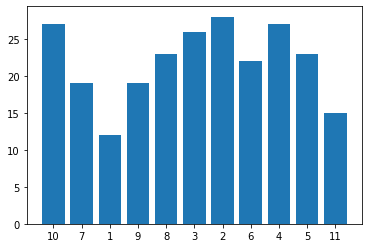

In [8]:
count_topics_per_user = defaultdict(int)

for user, topic in session_ids:
    count_topics_per_user[topic] += 1

plt.bar(range(len(count_topics_per_user)), list(count_topics_per_user.values()), align='center')
plt.xticks(range(len(count_topics_per_user)), list(count_topics_per_user.keys()))

plt.show()

In [9]:
all_sequences = get_all_sequences(path_log, session_ids)

#all_sequences

In [10]:
def get_transitions(sequence, max_sub_topic, include_rel = False):
    transitions = defaultdict(int)
    last_sub_topic = -1
    for action in sequence:
        current_sub_topic = action[0]
        sub_topic = action[3]
        rel = action[2]
        if not include_rel:
            transitions[(current_sub_topic, sub_topic)] += 1
        else:
            transitions[(current_sub_topic, sub_topic, rel)] += 1
        last_sub_topic = sub_topic
    if not include_rel:
        transitions[(last_sub_topic, max_sub_topic + 1)] += 1
    else:
        transitions[(last_sub_topic, max_sub_topic + 1, rel)] += 1
    return transitions

def aggregate_transitions(transitions_list):
    res = defaultdict(int)
    for transitions in transitions_list:
        for key in transitions:
            res[key] += transitions[key]
    return res

def normalize_sub_topics(transitions, min_sub_topic):
    res = defaultdict(int)
    for key in transitions:
        if key[0] == 0:
            res[(key[0], key[1] - min_sub_topic + 1)] = transitions[key]
        else:
            res[(key[0] - min_sub_topic + 1, key[1] - min_sub_topic + 1)] = transitions[key]
    return res

all_transitions = defaultdict(list)
for topic in all_sequences.keys():
    sequences = all_sequences[topic]
    transitions_list = []
    for sequence in sequences:
        transitions = get_transitions(sequence, max(sub_topics[topic]))
        transitions_list.append(transitions)
    all_transitions[topic] = normalize_sub_topics(aggregate_transitions(transitions_list), min(sub_topics[topic]))
    
#all_transitions

# Fitting the best Alpha

In [11]:
gp = defaultdict(int)
for topic in all_sequences:
    for sequence in all_sequences[topic]:
        for m, _ in enumerate(sequence):
            gp[m] += 1

ngp = np.array([value for key, value in gp.items()])
ngp = ngp / np.sum(ngp)

ngp

array([0.203, 0.165, 0.158, 0.141, 0.115, 0.078, 0.052, 0.033, 0.022,
       0.011, 0.008, 0.005, 0.005, 0.003, 0.002])

In [12]:
# CP

def dd_cp():
    return 1

def d_cp(m): # precision
    res = 0.0
    n = 0.0
    for topic_id, topic in enumerate(topics):
        for sequence in all_sequences[topic]:
            if m < len(sequence):
                res += dd_cp()
                n += 1.0
    return res/n

# CBP

def dd_cbp(alpha, m):
    return alpha ** m

def d_cbp(alpha, m): # cbp
    res = 0.0
    n = 0.0
    for topic_id, topic in enumerate(topics):
        for sequence in all_sequences[topic]:
            if m < len(sequence):
                #norm = 0.0
                #for i, _ in enumerate(sequence):
                    #norm += dd_cbp(alpha, i)
                res += dd_cbp(alpha, m)#/norm
                n += 1.0
            
    return res/n

# CBP +

def dd_cbp_p(alpha, beta, m, sequence):
    res = 1.0
    for action in sequence[:m]:
        if action[2] == 'relevant':
            res *= alpha
        else:
            res *= beta
    for _ in range(m - len(sequence)):
        res *= beta
    return res

def d_cbp_p(alpha, beta, m):
    res = 0.0
    n = 0.0
    for topic_id, topic in enumerate(topics):
        for sequence in all_sequences[topic]:
            if m < len(sequence):
                res += dd_cbp_p(alpha, beta, m, sequence)
                n += 1.0
    return res/n

for i in range(15):
    print(d_cbp_p(1.0, 0.8, i), d_cbp(0.8, i), d_cp(i), ngp[i])

1.0 1.0 1.0 0.2030328559393429
0.966326530612245 0.8000000000000004 1.0 0.16512215669755687
0.9270588235294119 0.6400000000000005 1.0 0.15754001684919966
0.883017964071856 0.5120000000000003 1.0 0.14069081718618365
0.8331999999999993 0.4095999999999992 1.0 0.11457455770850884
0.7605264516129028 0.32768000000000064 1.0 0.07834877843302443
0.6639132903225807 0.2621439999999997 1.0 0.05223251895534962
0.6115393641025644 0.20971519999999996 1.0 0.03285593934288121
0.5413500061538463 0.16777216000000014 1.0 0.02190395956192081
0.4360169944615385 0.13421772800000006 1.0 0.010951979780960405
0.37397704248888897 0.10737418240000006 1.0 0.007582139848357203
0.3099033600000001 0.08589934592000005 1.0 0.005054759898904802
0.2649893546666668 0.06871947673600004 1.0 0.005054759898904802
0.2643148800000001 0.054975581388800036 1.0 0.003369839932603201
0.15099494400000008 0.043980465111040035 1.0 0.0016849199663016006


## Precision@Length Model

In [13]:
min_err = sys.float_info.max
res = 100
M = len(ngp)
gt = ngp

def tse_cp():
    norm = 0.0
    for i in range(M):
        norm += d_cp(i)
    err = 0.0
    y_cp = []
    for i in range(M):
        val = d_cp(i)/norm
        y_cp.append(val)
        err += (gt[i]-val)**2
    return err, y_cp

min_err, y_cp = tse_cp()

print("l(TSE) = {:.4f}".format(np.log(min_err)))

def tae_cp():
    norm = 0.0
    for i in range(M):
        norm += d_cp(i)
    err = 0.0
    for i in range(M):
        val = d_cp(i)/norm
        err += abs(gt[i]-val)        
    return err

print("l(TAE) = {:.4f}".format(np.log(tae_cp())))

def kl_cp():
    norm = 0.0
    for i in range(M):
        norm += d_cp(i)
    err = 0.0
    for i in range(M):
        val = d_cp(i)/norm
        err += -gt[i] * np.log(val/gt[i])        
    return err

print("KL = {:.4f}".format(kl_cp()))

l(TSE) = -2.6560
l(TAE) = -0.0849
KL = 0.5522


## Conversational Biased Precision Model

In [14]:
min_err = sys.float_info.max
res = 100
best_alpha = -1
M = len(ngp)
gt = ngp

y_cbp = []
def tse_cbp(a):
    y_cbp = []
    norm = 0.0
    for i in range(M):
        norm += d_cbp(a, i)
    err = 0.0
    for i in range(M):
        val = d_cbp(a, i)/norm
        y_cbp.append(val)
        err += (gt[i]-val)**2
    return err, y_cbp

for a_i, a in enumerate(tqdm(np.linspace(0, 1, res+1))):        
    err, _y_cbp = tse_cbp(a)
        
    if err < min_err:
        min_err = err
        best_alpha = a
        y_cbp = _y_cbp

best_alpha_cbp = best_alpha

print("a =", best_alpha) 
print("l(TSE) = {:.4f}".format(np.log(min_err)))

def tae_cbp(a):
    norm = 0.0
    for i in range(M):
        norm += d_cbp(a, i)
    err = 0.0
    for i in range(M):
        val = d_cbp(a, i)/norm
        err += abs(gt[i]-val)        
    return err

print("l(TAE) = {:.4f}".format(np.log(tae_cbp(best_alpha))))

def kl_cbp(a):
    norm = 0.0
    for i in range(M):
        norm += d_cbp(a, i)
    err = 0.0
    for i in range(M):
        val = d_cbp(a, i)/norm
        err += -gt[i] * np.log(val/gt[i])        
    return err

print("KL = {:.4f}".format(kl_cbp(best_alpha)))


a = 0.79
l(TSE) = -5.5757
l(TAE) = -1.6224
KL = 0.0420


## Conversational Biased Precision + Model

In [15]:
min_err = sys.float_info.max
res = 100
best_alpha = -1
best_beta = -1
M = len(ngp)
gt = ngp

y_cbp_p = []
def tse_cbp_p(a, b):
    y_cbp_p = []
    err = 0.0
    norm = 0.0
    for i in range(M):
        norm += d_cbp_p(a, b, i)
    for i in range(M):
        val = d_cbp_p(a, b, i)/norm
        y_cbp_p.append(val)
        err += (gt[i]-val)**2
    return err, y_cbp_p

for a_i, a in enumerate(tqdm(np.linspace(0, 1, 1*res+1))):      
    
    for b_i, b in enumerate(np.linspace(0, 1, res+1)):        
    
        err, _y_cbp_p = tse_cbp_p(a, b)

        if err < min_err:
            min_err = err
            best_alpha = a
            best_beta = b
            y_cbp_p = _y_cbp_p


best_alpha_cbp_p = best_alpha
best_beta_cbp_p = best_beta

print("a =", best_alpha, "b =", best_beta)
print("l(TSE) = {:.4f}".format(np.log(min_err)))

def tae_cbp_p(a, b):
    norm = 0.0
    for i in range(M):
        norm += d_cbp_p(a, b, i)
    err = 0.0
    for i in range(M):
        val = d_cbp_p(a, b, i)/norm
        err += abs(gt[i]-val)        
    return err

print("l(TAE) = {:.4f}".format(np.log(tae_cbp_p(best_alpha, best_beta))))

def kl_cbp_p(a, b):
    norm = 0.0
    for i in range(M):
        norm += d_cbp_p(a, b, i)
    err = 0.0
    for i in range(M):
        val = d_cbp_p(a, b, i)/norm
        err += -gt[i] * np.log(val/gt[i])        
    return err

print("KL = {:.4f}".format(kl_cbp_p(best_alpha, best_beta)))


a = 1.0 b = 0.32
l(TSE) = -7.5836
l(TAE) = -2.6969
KL = 0.0169


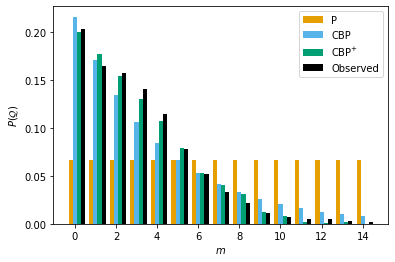

In [16]:
x = np.arange(M)

bar_width = 0.20

plt.bar(x-bar_width*1, y_cp, width = bar_width, color='#E69F00', align='center', label='P')
plt.bar(x+bar_width*0, y_cbp, width = bar_width, color='#56B4E9', align='center', label='CBP')
plt.bar(x+bar_width*1, y_cbp_p, width = bar_width, color='#009E73', align='center', label="CBP$^{+}$")
plt.bar(x+bar_width*2, gt, width = bar_width, color='black', align='center', label="Observed")

#plt.rc('font', size=13)
plt.ylabel('$P(\\mathcal{Q})$')
plt.xlabel('$m$')

plt.legend()
plt.savefig("probability_of_querying.png", dpi=300)

# Condition Probability Analysis

## Same vs Other Topic

In [17]:
probs = defaultdict(int)
transitions_tables = {}
for topic_id, topic in enumerate(topics):
    sequences = all_sequences[topic]
    
    for sequence in sequences:
        #print(sequence)
        prev_item = sequence[0]
        for item in sequence[1:]:
            if prev_item[2] == 'relevant':
                if item[3] == prev_item[3]:
                    #print("rel, same topic")
                    probs["same | rel"] += 1
                else:
                    #print("rel, different")
                    probs["different | rel"] += 1
            else:
                if item[3] == prev_item[3]:
                    #print("not_rel, same")
                    probs["same | not_rel"] += 1
                else:
                    #print("not_rel, different")
                    probs["different | not_rel"] += 1
            prev_item = item
    
norm_rel = sum([value for key, value in probs.items() if "not_rel" not in  key])
norm_not_rel = sum([value for key, value in probs.items() if "not_rel" in  key])

for key, value in probs.items():
    if "not_rel" not in key:
        print(key, value / norm_rel)
        probs[key] = value/norm_rel
    else: 
        print(key, value / norm_not_rel)
        probs[key] = value/norm_not_rel

same | not_rel 0.3386454183266932
different | not_rel 0.6613545816733067
different | rel 0.8805755395683453
same | rel 0.11942446043165468


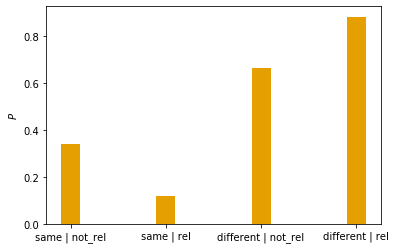

In [18]:
x = ['same | not_rel', 'same | rel', 'different | not_rel', 'different | rel']

bar_width = 0.20

y = [probs['same | not_rel'], probs['same | rel'], probs['different | not_rel'], probs['different | rel']]

plt.bar(x, y, width = bar_width, color='#E69F00', align='center')

#plt.rc('font', size=13)
plt.ylabel('$P$')

#plt.savefig("probability_of_querying.png", dpi=300)
plt.show()

## Influence of a Relevant Document to the next Subtopic

In [20]:
# from users
# topic -> sub_topic -> paragraphs
qrels_users = {}

for topic in sub_topics:
    for sequence in all_sequences[topic]:
        for action in sequence:
            paragraph = action[1]
            rel = action[2]
            sub_topic = action[3]
            if rel == 'relevant':
                if topic not in qrels_users:
                    qrels_users[topic] = {}
                if sub_topic not in qrels_users[topic]:
                    qrels_users[topic][sub_topic] = set()
                qrels_users[topic][sub_topic].add(paragraph)

#qrels_users

In [21]:
# topic -> sub_topic -> paragraphs
qrels = defaultdict(dict)

sub_topic_to_paragraph = defaultdict(set)
with open(path_retrievable_paragraph) as f:
    for line in f.readlines()[1:]:
        items = line.split('\t')
        sub_topic = int(items[0])
        paragraph = int(items[1])
        sub_topic_to_paragraph[sub_topic].add(paragraph)

sub_topics = get_sub_topics(path_sub_topic)

for topic in sub_topics:
    for sub_topic in sub_topics[topic]:
        qrels[topic][sub_topic] = sub_topic_to_paragraph[sub_topic]

#qrels

In [22]:
#P(of quering a sub_topic to which the examined document belongs | current doc is relevant to the current query and the queried sub_topic)

def get_rel_sub_topics(document, topic):
    rel_sub_topics = set()
    for sub_topic in qrels_users[topic]:
        if document in qrels_users[topic][sub_topic]:
            rel_sub_topics.add(sub_topic)
    return rel_sub_topics

probs = defaultdict(int)

num = 0
den = 0
for topic in topics:
    sequences = all_sequences[topic]
    for sequence in sequences:
        prev_action = sequence[0]
        for action in sequence[1:]:
            rel_sub_topics = get_rel_sub_topics(prev_action[1], topic)
            if prev_action[2] == 'relevant' and prev_action[1] != action[1] and len(rel_sub_topics) > 1:
                #print(prev_action, action, get_rel_sub_topics(prev_action[1], topic))
                if action[3] in rel_sub_topics:
                    num += 1
                den += 1
            prev_action = action
            
print(num, den, num/den)

35 316 0.11075949367088607


## How many times our qrels agree with the user relevance?

In [23]:
probs = defaultdict(int)
transitions_tables = {}

for topic in topics:
    sequences = all_sequences[topic]
    for sequence in sequences:
        for action in sequence[1:]:
            #print(action)
            if action[2] == 'relevant':
                probs["TP"] += 1
            else:
                probs["FP"] += 1
            
norm = sum(probs.values())
for key, value in probs.items():
    print(key, value / norm)
print(norm)

print(probs["TP"]/norm)

FP 0.2928118393234672
TP 0.7071881606765328
946
0.7071881606765328


# Correlation Analysis (CBS score vs Satisfaction)

In [53]:

# CP

def dd_cp(alpha, m, l):
    return 1

def ncp(sequence):
    res = 0.0
    for action in sequence:
        if action[2] == 'relevant':
            res += dd_cp(None, None, None)
    return res/len(sequence)

def get_ncp_list(sequences):
    res = []
    for sequence in sequences:
        res.append(ncp(sequence))
    return res

# CBP

def dd_cbp(alpha, m, l = None):
    return alpha ** m

def dd_ncbp(alpha, m, l):
    norm = 0.0
    for i in range(l):
        norm += dd_cbp(alpha, i, l)
    return dd_cbp(alpha, m, l) / norm

def ncbp(sequence, alpha):
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_ncbp(alpha, m, len(sequence))
    return res

def get_ncbp_list(sequences, alpha):
    res = []
    for sequence in sequences:
        res.append(ncbp(sequence, alpha))
    return res

# CBP +

def dd_ncbp_p(alpha, beta, m, sequence):
    res = 1.0
    for action in sequence[:m]:
        if action[2] == 'relevant':
            res *= alpha
        else:
            res *= beta
    norm = 0.0
    for i in range(len(sequence)):
        norm += dd_cbp(alpha, i)
    return res/norm

def ncbp_p(sequence, alpha, beta):
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_ncbp_p(alpha, beta, m, sequence)
    return res

def get_ncbp_p_list(sequences, alpha, beta):
    res = []
    for sequence in sequences:
        res.append(ncbp_p(sequence, alpha, beta))
    return res

In [68]:
ncbp_p_scores = []
ncbp_scores = []
ncp_scores = []

print(best_alpha_cbp_p, best_beta_cbp_p)
print(best_alpha_cbp)

for topic in topics:
    sequences = all_sequences[topic]
    if(len(sequences) > 0):
        ncbp_p_scores.append((topic, get_ncbp_p_list(sequences, best_alpha_cbp_p, best_beta_cbp_p)))
        ncbp_scores.append((topic, get_ncbp_list(sequences, best_alpha_cbp)))
        ncp_scores.append((topic, get_ncp_list(sequences)))
    
#ncbp_p_scores, ncbp_scores, ncp_scores

1.0 0.32
0.79


In [87]:
# new version
def get_satisfaction(lines):
    reg_exp = RegExp()
    satisfaction = None
    for line in lines:
        items = line.split('\t')
        content = items[2]
        if reg_exp.get(r'user is (.+)', content):
            satisfaction = reg_exp.res
    return satisfaction

# new
def get_all_satisfactions(path_log, session_ids):
    res = defaultdict(list)
    for session_id in session_ids:
        selected_lines = []
        with open(path_log) as f:
            for line in f.readlines()[1:]:
                items = line.split('\t')
                user = items[3].strip()
                topic = int(items[4].strip())
                if user == session_id[0] and topic == session_id[1]:
                    selected_lines.append(line)

        satisfaction = get_satisfaction(selected_lines)
        res[session_id[1]].append(satisfaction)
    return res

all_satisfactions = get_all_satisfactions(path_log, session_ids)

satisfaction_scores = []
for topic in topics:
    satisfactions = all_satisfactions[topic]
    if len(satisfactions) > 0:
        satisfaction_score = []
        for satisfaction in satisfactions:
            if satisfaction == 'satisfied':
                #satisfaction_score += 1
        #satisfaction_score /= len(satisfactions)
                satisfaction_score.append(1.0)
            else:
                satisfaction_score.append(0.0)
        satisfaction_scores.append((topic, satisfaction_score))
        
satisfaction_scores = sorted(satisfaction_scores)
#satisfaction_scores

In [78]:
def unpack(l):
    return [np.mean(i[1]) for i in l]
    #return functools.reduce(list.__add__, [i[1] for i in l])

print("CBP+", scipy.stats.kendalltau(unpack(ncbp_p_scores), unpack(satisfaction_scores)))
print("CBP", scipy.stats.kendalltau(unpack(ncbp_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.kendalltau(unpack(ncp_scores), unpack(satisfaction_scores)))

print("CBP+", scipy.stats.spearmanr(unpack(ncbp_p_scores), unpack(satisfaction_scores)))
print("CBP", scipy.stats.spearmanr(unpack(ncbp_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.spearmanr(unpack(ncp_scores), unpack(satisfaction_scores)))

print("CBP+", scipy.stats.pearsonr(unpack(ncbp_p_scores), unpack(satisfaction_scores)))
print("CBP", scipy.stats.pearsonr(unpack(ncbp_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.pearsonr(unpack(ncp_scores), unpack(satisfaction_scores)))

CBP+ KendalltauResult(correlation=0.6482593132545565, pvalue=0.006117582447622464)
CBP KendalltauResult(correlation=0.7223460919122202, pvalue=0.002252739154933953)
P KendalltauResult(correlation=0.6853027025833884, pvalue=0.0037547436251961193)
CBP+ SpearmanrResult(correlation=0.7625650275119625, pvalue=0.006350520569425186)
CBP SpearmanrResult(correlation=0.831058892258546, pvalue=0.0015265983452635986)
P SpearmanrResult(correlation=0.8173601193092295, pvalue=0.002123165628965581)
CBP+ (0.895775045068781, 0.00019150677188840314)
CBP (0.8808739887980555, 0.0003417224415667421)
P (0.9157449250833796, 7.57466248948151e-05)


KendalltauResult(correlation=0.8181818181818182, pvalue=0.00013227513227513228)


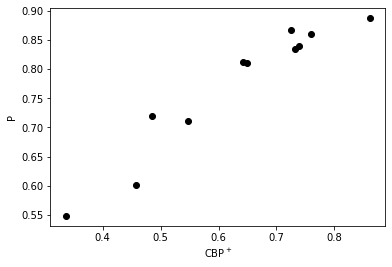

In [83]:
plt.plot(unpack(ncbp_p_scores), unpack(ncp_scores), 'o', color='black')

plt.xlabel('CBP$^+$')
plt.ylabel('P')

plt.savefig("CBP_P_vs_P.png", dpi=300)
print(scipy.stats.kendalltau(unpack(ncbp_p_scores), unpack(ncp_scores)))

KendalltauResult(correlation=0.8909090909090909, pvalue=1.3728555395222063e-05)


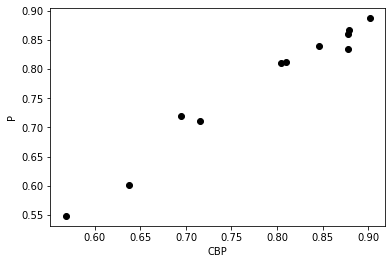

In [85]:
plt.plot(unpack(ncbp_scores), unpack(ncp_scores), 'o', color='black')

plt.xlabel('CBP')
plt.ylabel('P')

plt.savefig("CBP_vs_P.png", dpi=300)
print(scipy.stats.kendalltau(unpack(ncbp_scores), unpack(ncp_scores)))

KendalltauResult(correlation=0.7818181818181819, pvalue=0.0003334435626102293)


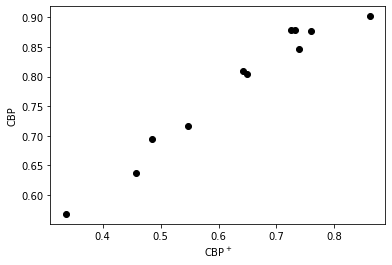

In [86]:
plt.plot(unpack(ncbp_p_scores), unpack(ncbp_scores), 'o', color='black')

plt.xlabel('CBP$^+$')
plt.ylabel('CBP')

plt.savefig("CBP_P_vs_CBP.png", dpi=300)
print(scipy.stats.kendalltau(unpack(ncbp_p_scores), unpack(ncbp_scores)))